# Discretization
*In machine learning, a discretizer is used to convert continuous numerical features into discrete (categorical or binned) values. This process is often called discretization or binning.*

> Discretization can be useful for several reasons:

1. To Make Models Simpler and More Interpretable
    - Some models can be easier to understand and perform better when continuous data is converted into meaningful intervals.
2. To Handle Non-Linear Relationships
    - Example:
        - Suppose probability of disease spikes above age 60.
        - A bin like “> 60” captures that threshold much better than a raw number.
3. To Reduce the Impact of Outliers
    - Binning can help mitigate the influence of extreme values.
        - Discretized features can be more stable, especially in:
            - small datasets
            - noisy data
            - skewed distributions
            - data with outliers
4. To Reduce Noise
    - Continuous features may contain small fluctuations that aren’t meaningful.
    - Bins smooth out this noise.
#### This Notebook will cover Equal-width binning Equal-frequency binning using the `KBinsDiscretizer` from `sklearn.preprocessing`.

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing as prep
from sklearn.utils.extmath import density

# Import the `Titanic_dataset` from the `data` folder

data = pd.read_csv('../data/titanic_dataset.csv')

# Explore the dataset
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  100 non-null    int64  
 1   Survived     100 non-null    int64  
 2   Pclass       100 non-null    int64  
 3   Name         100 non-null    object 
 4   Sex          100 non-null    object 
 5   Age          78 non-null     float64
 6   SibSp        100 non-null    int64  
 7   Parch        100 non-null    int64  
 8   Ticket       100 non-null    object 
 9   Fare         100 non-null    float64
 10  Cabin        20 non-null     object 
 11  Embarked     99 non-null     object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.5+ KB
None
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                        

#### This part in not really need but good for understanding **Summerize Missing Values in the Dataset**

In [2]:
# Check missing values per column
missing_values = data.isnull().sum() # Returns a DataFrame of booleans where True means the value is missing (NaN).

# Boolean mask where only columns with missing values are True
missing_cols = missing_values[missing_values > 0]

# If there are columns with missing values, Boolean mask will not be empty
if not missing_cols.empty:
    print("Columns with missing values:")
    print(missing_cols)
else:
    print("No missing values found in the dataset.")

Columns with missing values:
Age         22
Cabin       80
Embarked     1
dtype: int64


#### Next step is to handle the missing values
**Step 1:** Identify the numeric columns

In [3]:
numeric_data = data.select_dtypes(include=['int64', 'float64'])
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  100 non-null    int64  
 1   Survived     100 non-null    int64  
 2   Pclass       100 non-null    int64  
 3   Age          78 non-null     float64
 4   SibSp        100 non-null    int64  
 5   Parch        100 non-null    int64  
 6   Fare         100 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 5.6 KB


* **Step 2:** Handle missing values by filling them with the mean of the column
> median is usually preferred for missing values in numeric columns like Age

- Why median is often better
    - Median is robust to outliers.
    - Example: If most ages are 20–40, but a few passengers are 80–90, the mean would shift higher, while the median stays representative of the “typical” age.
    - Since discretization divides the range into bins, using the median avoids skewing the bins if the column has outliers.
- When to use mean
    - If the data is roughly symmetric and has no extreme outliers, the mean is fine.
    - For example, Fare might be skewed, so median is usually safer, but mean can also work.

In [4]:
numeric_data = numeric_data.fillna(numeric_data.median())
# Verify no missing values remain
print(numeric_data.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
dtype: int64


#### **Step 3:** Select the features you want to discretize
> For simplicity, we select only the first 2 numerical features (age and fare), convert them to a NumPy array, and visualize their distributions using histograms.

In [5]:
numeric_data = numeric_data[['Age', 'Fare']]
# Convert the dataframe to Numpy ndarray for KBinsDiscretizer
numeric_data_array = numeric_data.to_numpy()
# Check the type
print("Type:", type(numeric_data_array))
# Check the dtype
print("Data type:", numeric_data_array.dtype)
# Check the shape
print("Shape:", numeric_data_array.shape)

Type: <class 'numpy.ndarray'>
Data type: float64
Shape: (100, 2)


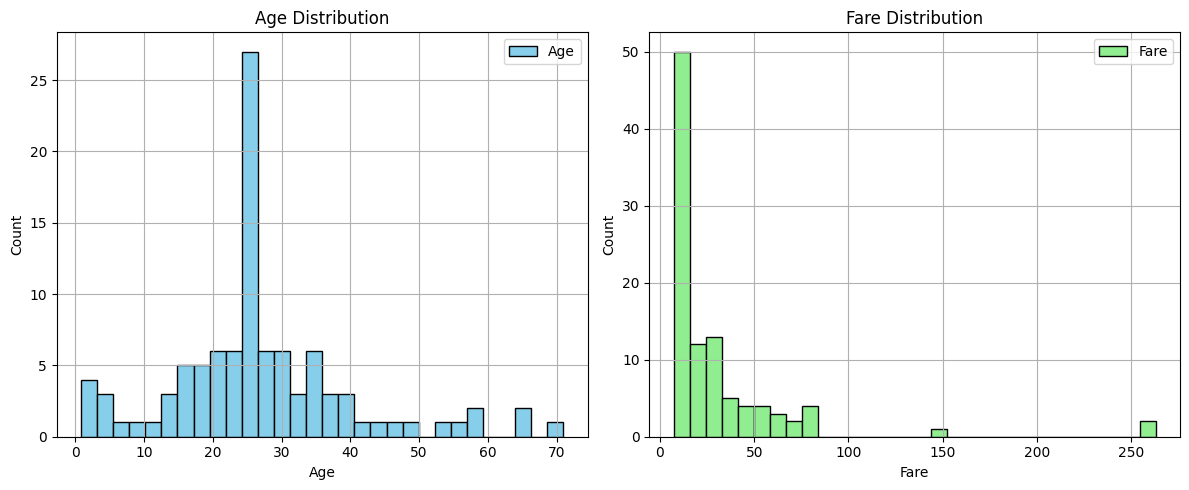

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Age histogram
numeric_data['Age'].hist(bins=30, ax=axes[0], color='skyblue', edgecolor='black', label='Age')
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
axes[0].legend()  # show legend

# Fare histogram
numeric_data['Fare'].hist(bins=30, ax=axes[1], color='lightgreen', edgecolor='black', label='Fare')
axes[1].set_title('Fare Distribution')
axes[1].set_xlabel('Fare')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()


### Equal Width Binning

- To use it, we must again follow the **"initialize → fit → transform"** process.

#### 1. Initialize
- `strategy = 'uniform'`
  - This tells `KBinsDiscretizer` to use **Equal Width Binning**.
- `n_bins = 3`
  - We want to divide the data range into **3 bins of equal width**.
  - *Note:* You can choose any number of bins based on analysis needs.
- `encode = 'ordinal'`
  - The output will be **ordinal integers** representing each bin.

#### 2. Fit
- The `fit()` step computes the **bin edges** by dividing the feature’s value range into **equal-width intervals**.

#### 3. Transform
- The `transform()` step assigns each numeric value to one of these intervals by producing its **bin index** (0, 1, 2, …).


In [7]:
ewb = prep.KBinsDiscretizer(n_bins=3, strategy='uniform', encode='ordinal')
# Fit and Transform
numeric_data_array_ewb = ewb.fit_transform(numeric_data_array)
print(ewb.bin_edges_)
print(numeric_data_array_ewb.shape)
# Make categorical by converting to string:
numeric_data_array_ewb_cat = numeric_data_array_ewb.astype(str)
# Transform back to data frame
numeric_data_ewb_cat = pd.DataFrame(numeric_data_array_ewb_cat, columns=numeric_data.columns)
print("Info", numeric_data_ewb_cat.info())

[array([ 0.83, 24.22, 47.61, 71.  ])
 array([  7.225     ,  92.48333333, 177.74166667, 263.        ])]
(100, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Age     100 non-null    object
 1   Fare    100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB
Info None


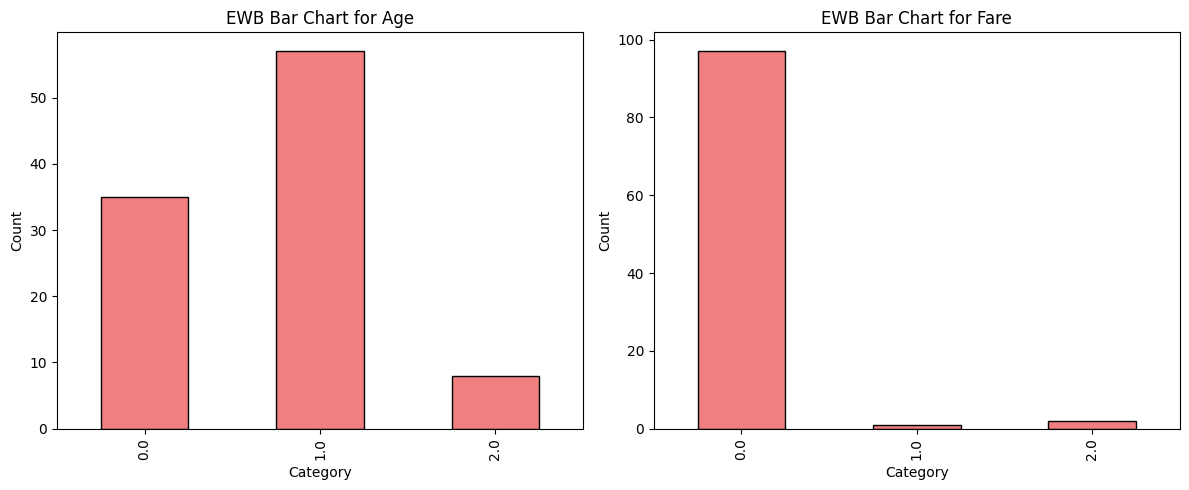

Age
1.0    57
0.0    35
2.0     8
Name: count, dtype: int64
Fare
0.0    97
2.0     2
1.0     1
Name: count, dtype: int64


In [8]:
# plot a bar chart of all features and compare it with the original data:
fig, axes = plt.subplots(1, len(numeric_data_ewb_cat.columns), figsize=(12, 5))
for i, col in enumerate(numeric_data_ewb_cat.columns):
    numeric_data_ewb_cat[col].value_counts().sort_index().plot.bar(ax=axes[i], color='lightcoral', edgecolor='black')
    axes[i].set_title(f'EWB Bar Chart for {col}')
    axes[i].set_xlabel('Category')
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()
# Print the value counts for each feature:
for col in numeric_data_ewb_cat.columns:
    print(numeric_data_ewb_cat[col].value_counts())

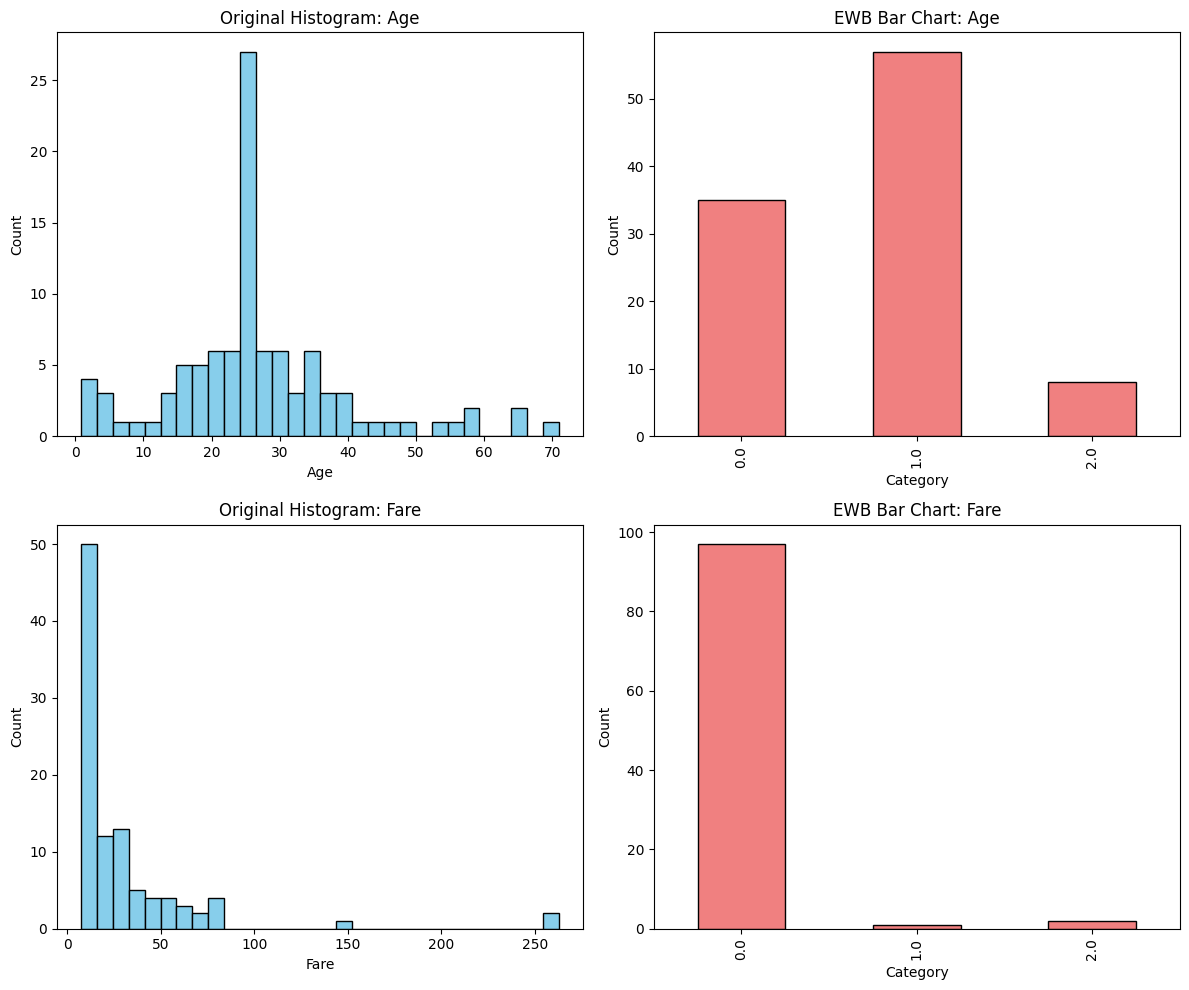

In [9]:
# We can compare the original histograms with the EWB bar charts side by side for better visualization:
# Number of features
n_features = len(numeric_data.columns)

fig, axes = plt.subplots(n_features, 2, figsize=(12, 5 * n_features))

for i, col in enumerate(numeric_data.columns):
    # Original numeric histogram
    axes[i, 0].hist(numeric_data[col], bins=30, color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f'Original Histogram: {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')

    # EWB-binned bar chart
    numeric_data_ewb_cat[col].value_counts().sort_index().plot.bar(
        ax=axes[i, 1], color='lightcoral', edgecolor='black'
    )
    axes[i, 1].set_title(f'EWB Bar Chart: {col}')
    axes[i, 1].set_xlabel('Category')
    axes[i, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Equal Frequency Binning (EFB)

- To use it, we must again follow the **"initialize → fit → transform"** process.

#### 1. Initialize
- `strategy = 'quantile'`
  - This tells `KBinsDiscretizer` to use **Equal Frequency Binning**.
- `n_bins = 3`
  - We want to divide the data into **3 bins**, each containing approximately the **same number of samples**.
  - *Note:* You can choose any number of bins based on analysis needs.
- `encode = 'ordinal'`
  - The output will be **ordinal integers** representing each bin.

#### 2. Fit
- The `fit()` step computes the **quantile thresholds** needed to split the data into bins of **equal frequency**.

#### 3. Transform
- The `transform()` step uses these quantile thresholds to assign each numeric value to a **bin index** (0, 1, 2, …).


[array([ 0.83, 23.  , 28.  , 71.  ])
 array([  7.225 ,   8.6625,  27.7208, 263.    ])]
(100, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Age     100 non-null    object
 1   Fare    100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB
Info None


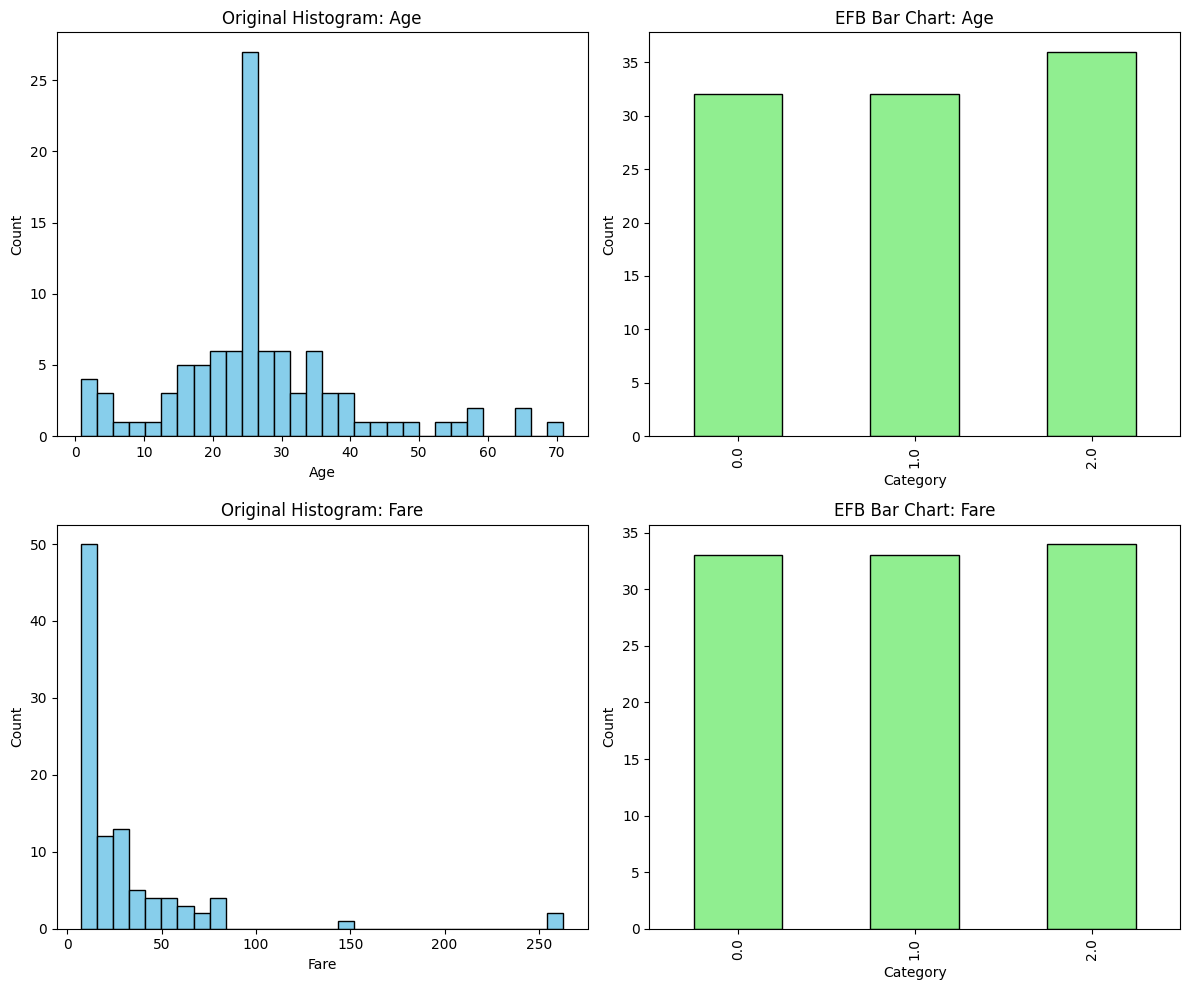

Age
2.0    36
0.0    32
1.0    32
Name: count, dtype: int64
Fare
2.0    34
0.0    33
1.0    33
Name: count, dtype: int64


In [10]:
# Initialize
efb = prep.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile', quantile_method='averaged_inverted_cdf')
# Fit and Transform
numeric_data_array_efb = efb.fit_transform(numeric_data_array)
print(efb.bin_edges_)
print(numeric_data_array_efb.shape)

# Make categorical by converting to string:
numeric_data_array_efb_cat = numeric_data_array_efb.astype(str)
# Transform back to data frame:
numeric_data_efb_cat = pd.DataFrame(numeric_data_array_efb_cat, columns=numeric_data.columns)
print("Info", numeric_data_efb_cat.info())

# Plot a bar chart of all features and compare it with the original data:
n_features = len(numeric_data.columns)
fig, axes = plt.subplots(n_features, 2 , figsize=(12, 5 * n_features))
for i, col in enumerate(numeric_data_efb_cat.columns):
    # original numeric histogram
    axes[i, 0].hist(numeric_data[col], bins=30, color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f'Original Histogram: {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')
    # EFB-binned bar chart
    numeric_data_efb_cat[col].value_counts().sort_index().plot.bar(
        ax=axes[i, 1], color='lightgreen', edgecolor='black'
    )
    axes[i, 1].set_title(f'EFB Bar Chart: {col}')
    axes[i, 1].set_xlabel('Category')
    axes[i, 1].set_ylabel('Count')
plt.tight_layout()
plt.show()
# Print the value counts for each feature:
for col in numeric_data_efb_cat.columns:
    print(numeric_data_efb_cat[col].value_counts())